In [1]:
import pandas as pd

C:\Users\voqua\AppData\Local\Temp\ipykernel_26400\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#not very efficient WR, cheap WR
myDF = pd.read_csv("../dataset/placementDecisions_rl_los_cost_3.csv")

In [3]:
myDF.shape

(13438, 13)

In [4]:
myDF.columns

Index(['Unnamed: 0', 'ocp_jl', 'ocp_wr', 'ocp_hd', 'class_mild', 'need',
       'placement', 'ocp_jl_low_los', 'ocp_jl_total', 'ocp_wr_low_los',
       'ocp_wr_total', 'ocp_hd_low_los', 'ocp_hd_total'],
      dtype='object')

In [5]:
myDF.drop(["Unnamed: 0", "ocp_jl", "ocp_wr", "ocp_hd"], inplace= True, axis = 1)

In [6]:
# one hot encoding  -> the target is "placement", so we don't need to encode this column, also bcz RandomForest can handle categorical target data
# work release = 0 | home detention = 1 | jail = 2
for ind, item in myDF.iterrows():
    if item['placement'] == 'work release':
        myDF['placement'].iat[ind] = '0'
    elif item['placement'] == 'home detention':
        myDF['placement'].iat[ind] = '1'
    elif item['placement'] == 'jail':
        myDF['placement'].iat[ind] = '2'

#object to int
myDF['placement'] = pd.to_numeric(myDF['placement'])

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## A random model acting as a baseline for performance comparison

In [11]:
y = myDF["placement"]
X = myDF.drop(["placement"], axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, random_state = 50)

In [13]:
rf3 = RandomForestClassifier(random_state= 50)
rf3.fit(X_train, y_train)

RandomForestClassifier(random_state=50)

In [16]:
rf3.feature_importances_

array([0.06128872, 0.12324917, 0.05081126, 0.05983026, 0.05773265,
       0.54066725, 0.05064217, 0.05577852])

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [15]:
y_pred = rf3.predict(X_test)
print('f1_score' + str(f1_score(y_test, y_pred, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_pred, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_pred, average ='weighted')))

f1_score0.7861069158846334
precision_score: 0.7867282161732415
recall_score: 0.7857142857142857


In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf3.predict_proba(X_test), multi_class='ovr' )

0.9146531364390639

## Fine-tuning a model and Optimizing the performance

In [17]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [18]:
param_grid = {'n_estimators': [100,150,200, 230], 'max_depth': [None, 5, 10], 
              'min_samples_leaf': [2, 5, 10],
              'min_samples_split': [2, 4, 6], 'max_features': ["sqrt", "log2", None]}

In [31]:
sh = HalvingGridSearchCV(rf3, param_grid, cv = 5, factor = 2, random_state=50).fit(X_train, y_train)

In [32]:
sh.best_params_

{'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 200}

In [33]:
rf2a = RandomForestClassifier(max_depth= 10, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 4, n_estimators = 200, random_state= 50)

In [34]:
rf2a.fit(X_train, y_train)
y_preda = rf2a.predict(X_test)
print('f1_score:' + str(f1_score(y_test, y_preda, average='weighted')))
print('precision_score: ' + str(precision_score(y_test, y_preda, average ='weighted')))
print('recall_score: ' + str(recall_score(y_test, y_preda, average ='weighted')))

f1_score:0.8250835909707966
precision_score: 0.8257233334333842
recall_score: 0.8263888888888888


In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, rf2a.predict_proba(X_test), multi_class='ovr' )

0.9363450678627325

## Applying Cross Validation to the model

In [36]:
#Home Detention
rf2a_0 = RandomForestClassifier(max_depth= 10, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 4, n_estimators = 200, random_state= 50)
placement_0 = y_test.copy()
placement_0[placement_0 == 0] = 3
placement_0[(placement_0 == 1) | (placement_0 == 2)] = 0
placement_0[placement_0 == 3] = 1
from sklearn.model_selection import cross_validate
cv_results_0 = cross_validate(rf2a_0, X_test, placement_0, cv = 3, scoring = 'roc_auc')
cv_results_0 

{'fit_time': array([0.508183  , 0.57256603, 0.52735782]),
 'score_time': array([0.02235341, 0.02050447, 0.02317262]),
 'test_score': array([1., 1., 1.])}

In [37]:
#Work Release
rf2a_1 = RandomForestClassifier(max_depth= 10, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 4, n_estimators = 200, random_state= 50)
placement_1 = y_test.copy()
placement_1[ placement_1 != 1] = 0
from sklearn.model_selection import cross_validate
cv_results_1 = cross_validate(rf2a, X_test, placement_1, cv = 3, scoring = 'roc_auc')
cv_results_1

{'fit_time': array([0.84487081, 0.88591123, 0.85632396]),
 'score_time': array([0.03234363, 0.03267074, 0.03390384]),
 'test_score': array([0.90162151, 0.89058046, 0.88155196])}

In [38]:
# placement 3 is Jail
rf2a_2 = RandomForestClassifier(max_depth= 10, max_features = 'log2', min_samples_leaf = 5,
 min_samples_split = 4, n_estimators = 200, random_state= 50)
placement_2 = y_test.copy()
placement_2[placement_2 == 1] = 0
placement_2[placement_2 == 2] = 1

from sklearn.model_selection import cross_validate
cv_results_2 = cross_validate(rf2a_2, X_test, placement_2, cv = 3, scoring = 'roc_auc')
cv_results_2

{'fit_time': array([0.83118534, 0.98765779, 0.88568711]),
 'score_time': array([0.03383732, 0.03761315, 0.03650665]),
 'test_score': array([0.91257341, 0.90145296, 0.89670442])}

## SHAP LIBRARY - DATA INTERPRETATION

In [24]:
import shap

c:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
explainer3 = shap.TreeExplainer(rf2a)
shap_values3 = explainer3(X_train)

In [16]:
rf3.classes_ #work release, home detention, jail

array([0, 1, 2], dtype=int64)

In [29]:
pd3_wr = pd.DataFrame(shap_values3[:,:,0].values, columns=rf2a.feature_names_in_)
pd3_hd = pd.DataFrame(shap_values3[:,:,1].values, columns=rf2a.feature_names_in_)
pd3_jl = pd.DataFrame(shap_values3[:,:,2].values, columns=rf2a.feature_names_in_)

In [30]:
pd3_wr.to_csv("pd3_wr_tuned.csv", index = False)
pd3_hd.to_csv("pd3_hd_tuned.csv", index = False)
pd3_jl.to_csv("pd3_jl_tuned.csv", index = False)

Home Detention

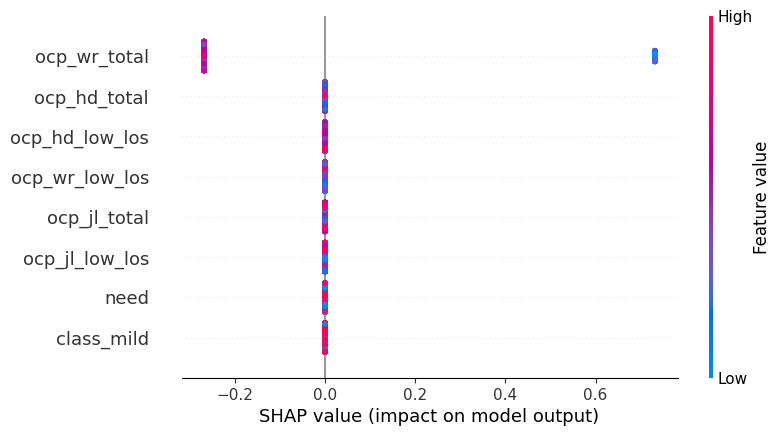

In [39]:
#tuned
shap.plots.beeswarm(shap_values3[:,:,0])

Work Release

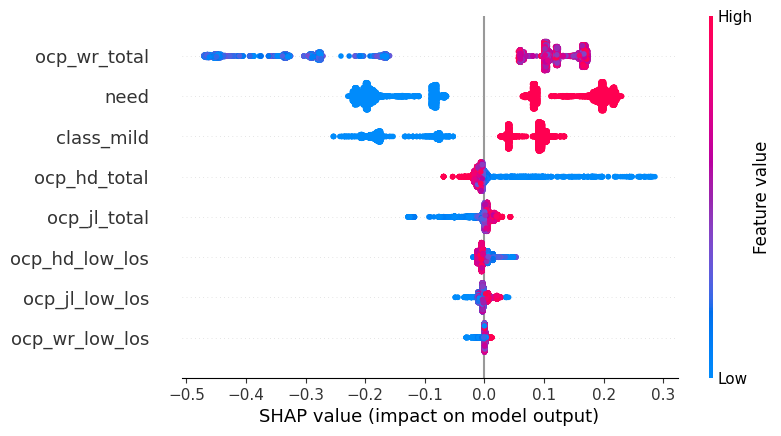

In [38]:
#tuned
shap.plots.beeswarm(shap_values3[:,:,1])

Jail

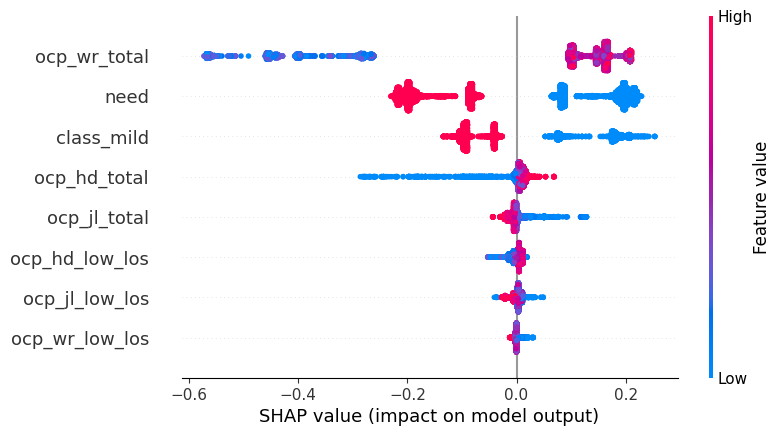

In [37]:
#tuned
shap.plots.beeswarm(shap_values3[:,:,2])

All 3 placements

In [34]:
shap_as_list = []
for i in range(len(rf3.classes_)):
    shap_as_list.append(shap_values3.values[:,:,i])

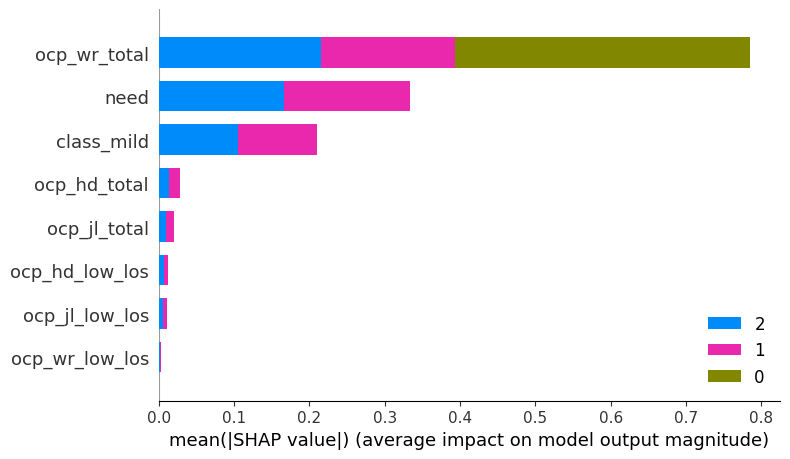

In [35]:
#tuned
shap.summary_plot(shap_as_list, X_train, plot_type ="bar", class_names= rf3.classes_)

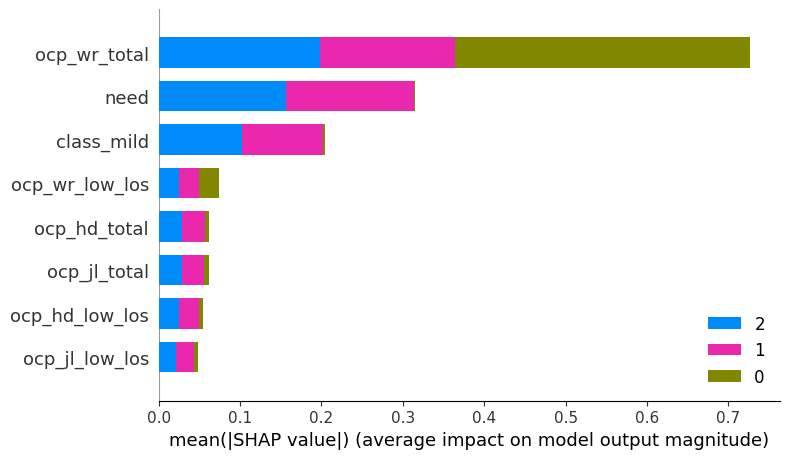

In [29]:
#pre_tuned
shap.summary_plot(shap_as_list, X_train, plot_type ="bar", class_names= rf3.classes_)

## Data Progression

<Axes: >

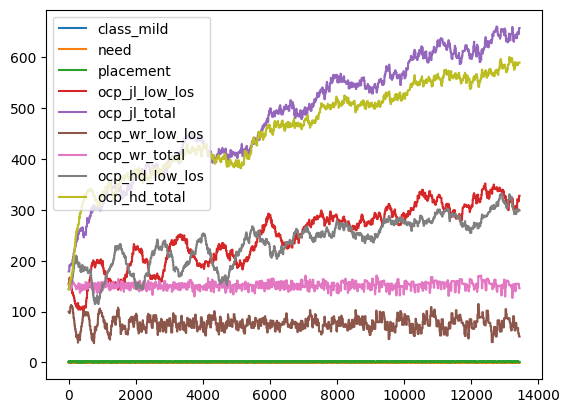

In [7]:
myDF.plot()